# The Problem

***We hope to provide a convinient and efficient way to forecast land-atmosphere boundary temperatures by utilizaing the ConvLSTM architecture over the region of Crete and for long temporal periods.***

In this work we used three different bands which share physical and chemical relation. 



1.   **Temperature of air at 2m height**
2.   **Skin Temperature which is essentially the surface temperature of earth**
3.   **Soil Temperature at the 1st level**



# Accessing Data

First we have to gain access to google drive, where our data are stored. In the next coding codeing cell we mount google drive.

***An alternative is to always upload our data directly to this google drive but this process has to occur everytime after we restore runtime***

In [ ]:
#Mount google drive
from google.colab import drive
#For authentication 
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Data

Our data are provided from the Google Earth Engine (GEE) platform and the ERA5 - Land Monthly Averaged dataset.\

The data are exported directly from the GEE platform in video format. We need a routine that can transform video to an array.\

scikit-video is state of the art library that serves this exact purpose 

In [ ]:
# This library provides easy access to common as well as state-of-the-art video processing routines.

! sudo pip install scikit-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.8 MB/s 


We are also going to utilize some libraries widely used in Data Science and Deep Learning applications and research. 

NumPy, Pandas, matplotlib are the important libraries we utilized

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

The following coding block executes the transition from data in video format to an array.

In [ ]:
import skvideo.io
videodata = skvideo.io.vread("/gdrive/MyDrive/Videos from GEE/20-20-32-100-1e6-21600-t2m-st-stl1-04-07-22-3-LHD--1--255--CRETE.mp4")
print(videodata.shape)

(8760, 12, 32, 3)


Our data are now a 4D Tensor.

**(frames, rows, cols, channels)**

## Preparing the Data

Because of ConvLSTM, tha architecture allows for 1 channel to be utilized and trained each time. 

We choose the first channel every time we train our model. Each time we use a different band as the first channel. The reaseon behind this is because in order to use the data correctly we have to consider the max and minimum temperatures (measured in Kelvin) of every layer of land and atmosphere and then normalize values between 0 and 255. (0 represents the coldest part of Crete and the most dark lit pixel of the heatmap and 255 the brightest lit pixel and the hottest part of Crete)


### Data Format

In order to utilize ConvLSTM we have to change our data from a 4D tensor to a 5D tensor.

**(samples, frames, rows, cols,channels)** 

We used a lot of different variations of data format. In our case the best scenario with the smallest error occured in a a format of 6 frames per sample where overlap occured.

i.e. 

n to n+5 frames in sample n
     
n+1 to n+6 frames in sample n+1

n+2 to n+7 frames in sample n+2

In [ ]:
pre_examples = []
dataset = []
dataset = np.array(dataset)

for i in range(videodata.shape[0]):
  
  #print("Value of i is " + str(i))

  if i <= (videodata.shape[0] - 6):

    pre_data = videodata[i:i+6, :, :, :]
    #print("\nPre Data is the following\n")
    #print(pre_data)
    #print("\nPre Data shape inside the for loop is the following: " + str(pre_data.shape)+ "\n")
    pre_examples.append(pre_data)
    #print("\nPre Examples is the following \n")
    #print(np.array(pre_examples))
    #print("\nPre Example - " + str(i) +  " - shape is the following: " + str(np.array(pre_examples).shape) + "\n")
  
  else:
     break

print('out of loop')

#print(pre_examples)
print("Examples shape is the following: " + str(np.array(pre_examples).shape))

dataset = np.array(pre_examples)
#print(dataset)

print("Dataset shape is the following: " + str(dataset.shape))
print(videodata.shape)

out of loop
Examples shape is the following: (1432, 8, 12, 32, 1)
Dataset shape is the following: (1432, 8, 12, 32, 1)
(1439, 12, 32, 1)


As expected we split data in training and testing.

We used the first 90% of samples for training and the rest 10% for testing

In [ ]:
#Split Dataset into training and testing datasets
indexes = np.arange(dataset.shape[0])

#np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]

train_index = train_index[:]
print(train_index.shape)


test_index = indexes[int(0.9 * dataset.shape[0]) :]

train_dataset = dataset[train_index]
print(test_index.shape)

print("Train Dataset shape is: " + str(train_dataset.shape))
test_dataset = dataset[test_index]
print("Test Dataset shape is: " + str(test_dataset.shape))

(1002,)
(430,)
Train Dataset shape is: (1002, 8, 12, 32, 1)
Test Dataset shape is: (430, 8, 12, 32, 1)


Variations of such a split exist in large. We could use completely random samples for training and use the unused samples for testing. But our model did not show any improvement. 

In [ ]:
# #Split Dataset into training and testing datasets
# indexes = np.arange(dataset.shape[0])
# np.random.shuffle(indexes)

# #np.random.shuffle(indexes)
# train_index = indexes[: int(0.9 * dataset.shape[0])]

# train_index = train_index[:]
# print(train_index.shape)


# test_index = indexes[int(0.9 * dataset.shape[0]) :]

# train_dataset = dataset[train_index]
# print(test_index.shape)

# print("Train Dataset shape is: " + str(train_dataset.shape))
# test_dataset = dataset[test_index]
# print("Test Dataset shape is: " + str(test_dataset.shape))

We normalize our data between 0 and 1 as it is accustomed in ML and DL problems. There is a deeper reason for following scaling our data. ConvLSTM makes use of a sigmoid which is a function with output values between 0 and 1.

In [ ]:
#Pixel values normalization
train_dataset = train_dataset / 255.0
test_dataset = test_dataset / 255.0
videodata = videodata / 255.0

In this particular coding block we split our data per sample. 

We desire to use the first 5 frames per sample as input and the last as output.
In order to only use the last frame as output we we will set as "True" the return sequences argument in our mopel.

We will show this in a next cell.

In [ ]:
#Define a function so that x is the first five frames and y is the sixth frame
#Those are inputs for the the training process
def assign_frames(data):
  x = data[:, 0 : dataset.shape[1] - 1, :, :, :]
  y = data[:, 1 : dataset.shape[1], :, :, :]
  return x, y

x_train, y_train = assign_frames(train_dataset)

print("Training Dataset Shape is: " + str(x_train.shape) + ", " + str(y_train.shape))
x_test, y_test = assign_frames(test_dataset)
print("Testing Dataset Shape is: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shape is: (1002, 7, 12, 32, 1), (1002, 7, 12, 32, 1)
Testing Dataset Shape is: (430, 7, 12, 32, 1), (430, 7, 12, 32, 1)


## Data Visualization

We make a first visualization of our data. We randomly choose samples and  visualize every frame in said sample.

In [ ]:
# Data visualization
for i in range (0, 4):
  
  fig, axes = plt.subplots(1, 6, figsize = (10,8))
  
  # Plot each of the sequential images for one random data example.
  
  data_choice = np.random.choice(train_dataset.shape[0], size = 1)[0]
  print(data_choice)
  
  for idx, ax in enumerate(axes.flat):
    
    image = ax.imshow(np.squeeze(train_dataset[data_choice][i]), cmap="hot")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
    
  print(f"Displaying frames for example/sample {data_choice}.")
  plt.show()

In the next three cells we visualize the time evolution of pixel value. We need to show that this evolution follows a trend simillar to a sin function. 

We then compare this time evolution to a visualization of the same pixels but the dataframe point of view. We extract via the GEE platform a dataframe for the pixels that correspond to A.  

In [ ]:
A = videodata
A = np.swapaxes(A, 0, 2)
print(A.shape)
A = A[16][6][:]
print(A.shape)
plt.plot(A)
plt.xlabel("Number of frames")
plt.ylabel("Pixel Value")
plt.title("Time evolution of pixel value")
plt.show


In [ ]:
B = new_videodata
B = np.swapaxes(B, 0, 2)
print(B.shape)
B = B[10][6][:]
print(B.shape)
plt.xlabel("Number of frames")
plt.ylabel("Pixel Value")
plt.title("Time evolution of pixel value")
plt.show
plt.plot(B)
plt.show

In [ ]:
C = new_videodata
C = np.swapaxes(C, 0, 2)
print(C.shape)
C = C[5][5][:]
print(C.shape)
plt.xlabel("Number of frames")
plt.ylabel("Pixel Value")
plt.title("Time evolution of pixel value")
plt.show
plt.plot(C)
plt.show

We use the pandas library to access the dataframe from GEE.

In [ ]:
data_panda = pd.read_csv("/gdrive/MyDrive/CSV folders of GEE/16-20 LMAHD t2m.csv")

In [ ]:
data_panda.plot.line(x='Time',y='temperature_2m',color='blue',legend=None)
plt.xticks(rotation=45)
plt.ylabel('Tempereture 2m (K)')
plt.xlabel('Time (Years)')
plt.title('Time Evolution of air temperature at 2m above ground level over Heraklion')
plt.show()

# The ConvLSTM Model

ConvLSTM is a model that the operation of convolution has replaced matrix multiplications of the LSTM architecture.



In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(0.0001))

In [ ]:
model.summary()

In [ ]:
# Define some callbacks to improve training.
#early_stopping = keras.callbacks.EarlyStopping(monitor="accuracy", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience = 2)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 10

# Fit the model to the training data.
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, callbacks = [reduce_lr])

Epoch 1/10
101/101 [==============================] - 67s 599ms/step - loss: 0.0536 - lr: 1.0000e-04
Epoch 2/10
101/101 [==============================] - 60s 598ms/step - loss: 0.0047 - lr: 1.0000e-04
Epoch 3/10
101/101 [==============================] - 61s 604ms/step - loss: 0.0024 - lr: 1.0000e-04
Epoch 4/10
101/101 [==============================] - 63s 619ms/step - loss: 0.0018 - lr: 1.0000e-04
Epoch 5/10
101/101 [==============================] - 61s 607ms/step - loss: 0.0012 - lr: 1.0000e-04
Epoch 6/10
101/101 [==============================] - 61s 602ms/step - loss: 0.0011 - lr: 1.0000e-04
Epoch 7/10
101/101 [==============================] - 61s 608ms/step - loss: 9.1326e-04 - lr: 1.0000e-04
Epoch 8/10
101/101 [==============================] - 61s 602ms/step - loss: 8.7085e-04 - lr: 1.0000e-04
Epoch 9/10
101/101 [==============================] - 61s 609ms/step - loss: 6.6367e-04 - lr: 1.0000e-04
Epoch 10/10
101/101 [==============================] - 62s 613ms/step - loss: 6

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'lr'])


# Results

We will evaluate our model by comparing the last frame from each samle in the testing dataset to every reconstructed prediction based on the first five frames from each sample.

We eill use the MSE and RMSE to keep track of the loss for the whole testing dataset and we will evaluate the precision and accuracy of each reconstructed image and how close it ressembles reality by using the Peak Signal to Noise Ratio (PSNR).

In [ ]:
plt.xlabel('Epochs')
plt.ylabel("Loss Magnitude")
plt.title('Training Loss')
plt.plot(history.history['loss'])
plt.show()

In [ ]:
psnr_1 = []

mse_1 = []


A = []
A_n = []

for i in range (test_dataset.shape[0]):

  example = test_dataset[i, :, :, :, :]
  
  frames = example[:5, :, :, :]
  # Pick the last frame from the example
  original_frame = example[5:6, :, :, :]

  # Predict the last frame.
  # Extract the model's prediction and post-process it.

  new_prediction = model.predict(np.expand_dims(frames, axis=0))
  print(new_prediction.shape)
  new_prediction = np.squeeze(new_prediction, axis=0)
  print(new_prediction.shape)
  predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
  print(predicted_frame.shape)
  # Construct a figure for the original and new frames.
  
  print(original_frame.shape)
  # Visualizing last frame from an example
  plt.imshow(np.squeeze(original_frame), cmap="hot", aspect="equal")
  plt.title(f"Original Frame from Example {i+1}")
  plt.colorbar()
  plt.show()


  # Plot new frames
  print(frames.shape)
  new_frame = predicted_frame
  print(new_frame.shape)
  plt.imshow(np.squeeze(new_frame), cmap="hot", aspect="equal")
  plt.title(f"New Frame for example {i+1}")
  plt.colorbar()
  # Display the figure.
  plt.show()

  A_n.append(new_frame)
  A.append(original_frame)
  
 
  psnr_1.append(tf.image.psnr(original_frame, new_frame, max_val=1.00))
  mse_1.append(tf.keras.metrics.mean_squared_error(
  original_frame, new_frame))



In [ ]:
psnr_1 = np.array(psnr_1)
print(psnr_1.shape)
print(np.mean(psnr_1))

mse_1 = np.array(mse_1)
mse_1 = mse_1.flatten()
print(mse_1.shape)
print(np.mean(mse_1))

rmse_1 = np.sqrt(np.mean(mse_1))
print(rmse_1)

print("The Root Mean Squared Error (RMSE) is " + str(31.304*rmse_1) + " degrees Celsius")

In [ ]:
A_n = np.array(A_n)
A = np.array(A)

print(A_n.shape)
print(A.shape)

(430, 1, 12, 32, 1)
(430, 1, 12, 32, 1)


To evaluate our model we test the model performance in the four major cities in Crete. We happed their pixel in the GEE platform and the results are as follow.

In [ ]:
B_n = np.array(A_n)
B = np.array(A)

print(B_n.shape)
print(B.shape)


B_n = np.swapaxes(A_n, 0, 2)
B = np.swapaxes(A, 0, 2)

C_n = np.swapaxes(B_n, 1, 3)
C = np.swapaxes(B, 1, 3)

D_n = np.swapaxes(C_n, 2, 3)
D = np.swapaxes(C, 2, 3)

print(D_n.shape)
print(D.shape)


E_n = D_n[5][17][0][:] 
E = D[5][17][0][:] 


print(E_n.shape)
print(E.shape)

K_n = E_n*float(31.304)
K = E*float(31.304)

T_n = K_n.tolist() 
T = K.tolist()
x = np.linspace(2017,2021,430)

plt.plot(x, T, label = " Temperature")
plt.plot(x, T_n, label = " Predicted Temperature")
plt.legend(loc = "best", fontsize='x-small')
plt.xlabel("Date (Year)")
# plt.xticks(np.arange(0, 50, 6))
plt.xticks(np.around(x), fontweight = 'normal')
plt.ylabel("Temperature in (\u00B0C)")
plt.yticks(np.arange(5, 30, 2.5))

plt.title("Temperature of air 2m at Heraklion")

plt.show()

In [ ]:
B_n = np.array(A_n)
B = np.array(A)

print(B_n.shape)
print(B.shape)


B_n = np.swapaxes(A_n, 0, 2)
B = np.swapaxes(A, 0, 2)

C_n = np.swapaxes(B_n, 1, 3)
C = np.swapaxes(B, 1, 3)

D_n = np.swapaxes(C_n, 2, 3)
D = np.swapaxes(C, 2, 3)

print(D_n.shape)
print(D.shape)


E_n = D_n[5][11][0][:]
E = D[5][11][0][:]
# A_n = np.squeeze(A_n)
# A = np.squeeze(A)

print(E_n.shape)
print(E.shape)

T_n = np.array(E_n*float(31.304))
T = np.array(E*float(29.26))
x = np.linspace(2017,2021,430)

plt.plot(x, T, label = " Temperature")
plt.plot(x, T_n, label = " Predicted Temperature")
plt.legend(loc = "upper left", fontsize='x-small')
plt.xlabel("Date (Year)")
plt.xticks(np.around(x))
plt.ylabel("Temperature in (\u00B0C)")
plt.yticks(np.arange(5, 30, 2.5))
plt.title("Temperature of air 2m at Rethymno")
plt.show()

In [ ]:
B_n = np.array(A_n)
B = np.array(A)

print(B_n.shape)
print(B.shape)


B_n = np.swapaxes(A_n, 0, 2)
B = np.swapaxes(A, 0, 2)

C_n = np.swapaxes(B_n, 1, 3)
C = np.swapaxes(B, 1, 3)

D_n = np.swapaxes(C_n, 2, 3)
D = np.swapaxes(C, 2, 3)

print(D_n.shape)
print(D.shape)


E_n = D_n[2][6][0][:]
E = D[2][6][0][:]
# A_n = np.squeeze(A_n)
# A = np.squeeze(A)

print(E_n.shape)
print(E.shape)

T_n = np.array(E_n*float(31.304))
T = np.array(E*float(31.304))
x = np.linspace(2017,2021,430)

plt.plot(x, T, label = " Temperature")
plt.plot(x, T_n, label = " Predicted Temperature")
plt.legend(loc = "lower right", fontsize='x-small')
plt.xlabel("Date (Year)")
plt.xticks(np.around(x))
plt.ylabel("Temperature in (\u00B0C)")
plt.yticks(np.arange(5, 30, 2.5))
plt.title("Temperature of air 2m at at Chania")
plt.show()

In [ ]:
B_n = np.array(A_n)
B = np.array(A)

print(B_n.shape)
print(B.shape)


B_n = np.swapaxes(A_n, 0, 2)
B = np.swapaxes(A, 0, 2)

C_n = np.swapaxes(B_n, 1, 3)
C = np.swapaxes(B, 1, 3)

D_n = np.swapaxes(C_n, 2, 3)
D = np.swapaxes(C, 2, 3)

print(D_n.shape)
print(D.shape)


E_n = D_n[7][25][0][:]
E = D[7][25][0][:]


print(E_n.shape)
print(E.shape)

T_n = np.array(E_n*float(31.304))
T = np.array(E*float(31.304))
x = np.linspace(2017,2021,430)

plt.plot(x,T, label = " Temperature")
plt.plot(x,T_n, label = " Predicted Temperature")
plt.legend(loc = "lower right", fontsize = "x-small" )
plt.xlabel("Date (Year)")
plt.xticks(np.around(x))
plt.ylabel("Temperature in (\u00B0C)")
plt.yticks(np.arange(5, 30, 2.5))
plt.title("Temperature of air 2m at Ag. Nikolaos")
plt.show()

We then proceed in making predictions not just a frame ahead of time but 6 frames/months ahead

In [ ]:
psnr_frw_pr = []

mse_frw_pr = []

psnr_frw_pr = []
mse_frw_pr = []

for k in range (30):

  idx = int(np.random.choice(test_dataset.shape[0], size = 1))
  print(idx)

  if idx <= 430:

    frames = videodata[idx:idx+7, :, :, :]
    print(frames.shape)

    original_frame = videodata[idx+7:idx+8, :, :, :]
  
  else: 

    idx = int(np.random.choice(videodata.shape[0], size = 1))
    print(idx)

  for j in range (6): 
    print(j)
    # Visualizing last frame from an example
    plt.imshow(np.squeeze(original_frame), cmap="hot", aspect="equal")
    plt.title(f"Original Frame {idx + 7 + j}")
    plt.colorbar()
    plt.show()

    # # Predict the last frame.
    # # Extract the model's prediction and post-process it.

    new_prediction = model.predict(np.expand_dims(frames, axis=0))

    new_prediction = np.squeeze(new_prediction, axis=0)

    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)


    # Plot new frames
    new_frame = predicted_frame
    print(new_frame.shape)
    plt.imshow(np.squeeze(new_frame), cmap="hot", aspect="equal")
    plt.title(f"New Frame {idx + 7 + j}")
    plt.colorbar()
    plt.show()

    psnr_frw_pr.append(tf.image.psnr(original_frame, new_frame, max_val=1.00))
    mse_frw_pr.append(tf.keras.metrics.mean_squared_error(
    original_frame, new_frame))

    print(frames.shape)
    frames = np.concatenate((frames[j+1:j+5], new_frame), axis = 0)
    print(frames.shape)


print(np.array(psnr_frw_pr))
print(np.mean(psnr_frw_pr))
print(np.mean(np.array(mse_frw_pr)))
print(np.mean(np.sqrt(np.array(mse_frw_pr))))



In [ ]:
psnr_frw_pr_re = np.reshape(np.array(psnr_frw_pr), [30,6])
print(psnr_frw_pr_re.shape)
print(psnr_frw_pr_re)


for i in range(6):
  psnr_2 = np.mean(psnr_frw_pr_re, axis = 0)

print(psnr_2.shape)
plt.plot(psnr_2)
plt.title("Peak Signal to Noise Ratio (PSNR) - Frames predicted ")
plt.xlabel("Number of frames")
plt.ylabel("Peak Signal to Noise Ratio (PSNR)")
plt.show()

mse_frw_pr_re = np.reshape(np.array(mse_frw_pr), [30,6,12,32])
print(mse_frw_pr_re.shape)
# mse_re = np.reshape(mse, [48,2,12,32])
# print(mse_re.shape)
mse_frw_pr_er = np.mean(mse_frw_pr_re, axis = 3)
print(mse_frw_pr_er.shape)
mse_f = np.mean(mse_frw_pr_er, axis = 2)
print(mse_f.shape)
mse_2 = np.mean(mse_f, axis = 0)

plt.plot(mse_2)
plt.title("Mean Squared Error (MSE) - Frames predicted")
plt.xlabel("Number of frames")
plt.ylabel("Mean Squared Error (MSE)")
plt.show()

plt.plot(np.sqrt(mse_2)*26.356)
plt.title("Root Mean Squared Error (RMSE) - Frames predicted")
plt.xlabel("Number of frames")
plt.ylabel("Root Mean Squared Error (RMSE) in (\u00B0C)")
plt.show()
  

Finally we evaluate our model to make prediction of a future frame without considering the in between months.

In [ ]:
psnr_3 = []

mse_3 = []

psnr_frame_1 = []

psrn_frame_2 = [] 

for i in range (test_dataset.shape[0]):

  example = test_dataset[i, :, :, :, :]
  frames = example[:3, :, :, :]
  # Pick the last two frames from the example
  original_frame_1 = example[3:8, :, :, :]
  print(original_frame_1.shape)

  for j in range (original_frame_1.shape[0]):

    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    print(new_prediction.shape)
    new_prediction = np.squeeze(new_prediction, axis=0)
    print(new_prediction.shape)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    print(predicted_frame.shape)
    new_frame = predicted_frame
    print(new_frame.shape)
    
    plt.imshow(np.squeeze(original_frame_1[j]), cmap="hot", aspect="equal")
    plt.title(f"Original Frame {j + 1} of example {i + 1}")
    plt.colorbar()
    plt.show()

    plt.imshow(np.squeeze(new_frame), cmap="hot", aspect="equal")
    plt.title(f"New Frame {j + 1} of example {i + 1}")
    plt.colorbar()
    plt.show()



    psnr_3.append(tf.image.psnr(original_frame_1[j], new_frame, max_val=1.00))
    mse_3.append(tf.keras.metrics.mean_squared_error(original_frame_1[j], new_frame))


(2150, 1)
(5,)


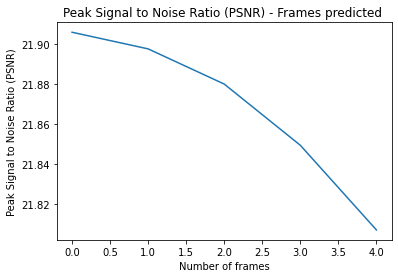

(430, 5, 12, 32)
(430, 5, 12)
(430, 5)


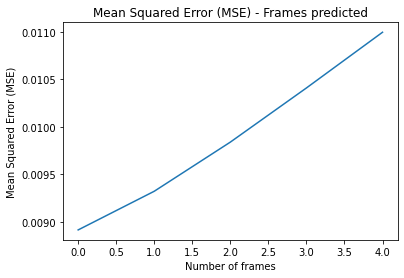

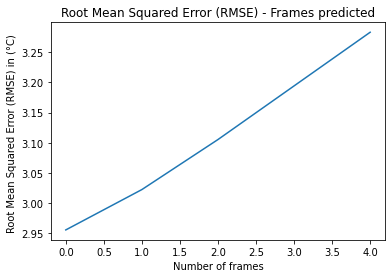

In [ ]:
psnr_3 = np.array(psnr_3)
print(psnr_3.shape)
psnr_3_re = np.reshape(psnr_3, (test_dataset.shape[0], 5))

psnr_3_er = np.mean(psnr_3_re, axis = 0)
print(psnr_3_er.shape)
plt.plot(psnr_3_er)
plt.title("Peak Signal to Noise Ratio (PSNR) - Frames predicted ")
plt.xlabel("Number of frames")
plt.ylabel("Peak Signal to Noise Ratio (PSNR)")
plt.show()

mse_3 = np.array(mse_3)
mse_3_re = np.reshape(mse_3, [430,5,12,32])
print(mse_3_re.shape)
mse_3_er = np.mean(mse_3_re, axis = 3)
print(mse_3_er.shape)
mse_3_f = np.mean(mse_3_er, axis = 2)
print(mse_3_f.shape)
mse_3_final = np.mean(mse_3_f, axis = 0)
plt.plot(mse_3_final)
plt.title("Mean Squared Error (MSE) - Frames predicted")
plt.xlabel("Number of frames")
plt.ylabel("Mean Squared Error (MSE)")
plt.show()

plt.plot(np.sqrt(mse_3_final)*31.304)
plt.title("Root Mean Squared Error (RMSE) - Frames predicted")
plt.xlabel("Number of frames")
plt.ylabel("Root Mean Squared Error (RMSE) in (\u00B0C) ")
plt.show()